In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from copy import deepcopy
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

In [2]:
# Download stopwords from nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/roman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Check downloaded stopwords in english
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [4]:
# Load dataset
df = pd.read_csv('./liar_dataset/train.tsv', delimiter='\t', header=None)
df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 
              'state', 'party', 'barely_true_counts', 'false_counts', 
              'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']

print(df)

               id        label  \
0       2635.json        false   
1      10540.json    half-true   
2        324.json  mostly-true   
3       1123.json        false   
4       9028.json    half-true   
...           ...          ...   
10235   5473.json  mostly-true   
10236   3408.json  mostly-true   
10237   3959.json    half-true   
10238   2253.json        false   
10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that 

In [5]:
# Select necessary columns
df = df[['label', 'statement']]

# Map labels to binary classification
df['label'] = df['label'].map({
    'true': 1, 
    'mostly-true': 1, 
    'half-true': 1, 
    'barely-true': 0, 
    'false': 0, 
    'pants-fire': 0
})
print(df)

       label                                          statement
0          0  Says the Annies List political group supports ...
1          1  When did the decline of coal start? It started...
2          1  Hillary Clinton agrees with John McCain "by vo...
3          0  Health care reform legislation is likely to ma...
4          1  The economic turnaround started at the end of ...
...      ...                                                ...
10235      1  There are a larger number of shark attacks in ...
10236      1  Democrats have now become the party of the [At...
10237      1  Says an alternative to Social Security that op...
10238      0  On lifting the U.S. Cuban embargo and allowing...
10239      0  The Department of Veterans Affairs has a manua...

[10240 rows x 2 columns]


In [9]:
df.head()

,label,statement
0,0,Says the Annies List political group supports ...
1,1,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,1,The economic turnaround started at the end of ...


In [10]:
# Show shape of the dataset
df.shape

(10240, 2)

In [11]:
# Show some info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      10240 non-null  int64 
 1   statement  10240 non-null  object
dtypes: int64(1), object(1)
memory usage: 160.1+ KB


In [12]:
# Take a copy from original training data
df_train_proc = deepcopy(df)

In [13]:
# Check about missing values to decide if we will make handling for it or not
df_train_proc.isnull().sum()

label        0
statement    0
dtype: int64

In [14]:
# Drop rows that contain at least one none value based on the title and text columns
df_train_proc = df_train_proc.dropna(subset=['statement', 'label'])
df_train_proc.shape

(10240, 2)

In [15]:
# Check about none values after handling missing values
df_train_proc.isnull().sum()

label        0
statement    0
dtype: int64

label
1    5752
0    4488
Name: count, dtype: int64


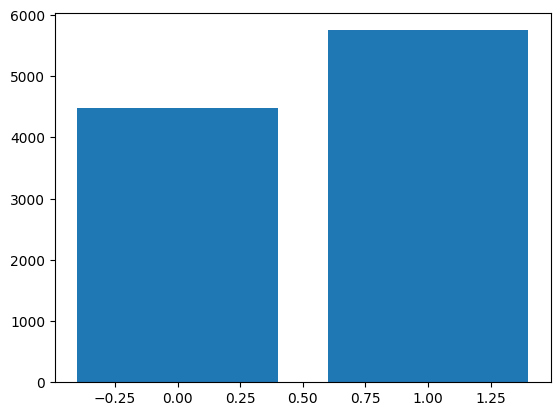

In [16]:
# Visualize label values to check about balancing of 0's and 1's
counts = df_train_proc['label'].value_counts()
print(counts)

# Plot result of each group
plt.bar(counts.index, counts)
plt.show()

In [17]:
# Split data into input and label data
X = df_train_proc['statement']
Y = df_train_proc['label']
print(f'X shape {X.shape}, Y shape {Y.shape}')

X shape (10240,), Y shape (10240,)


In [18]:
# Create porter stemmer to stemming data
stemmer = PorterStemmer()

In [19]:
# Create function to stem all words in the content
def stemming(content, stemmer):
    # Work on the alphabetical words only
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # Convert sentences into lower case sentences
    stemmed_content = stemmed_content.lower()
    # Split sentences into words
    stemmed_content = stemmed_content.split()
    
    # Get English stopwords
    stop_words = set(stopwords.words('english'))
    # Stem words
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if word not in stop_words]
    # Join words again
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

In [20]:
# Shwo the input data before stemming
X.head()

0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object

In [21]:
# Apply stemmer on the input data
X_stemmed = X.apply(lambda x: stemming(x, stemmer))

In [22]:
# Shwo the input data after stemming
X_stemmed.head()

0    say anni list polit group support third trimes...
1    declin coal start start natur ga took start be...
2    hillari clinton agre john mccain vote give geo...
3    health care reform legisl like mandat free sex...
4                     econom turnaround start end term
Name: statement, dtype: object

In [23]:
# Split data into train and test data
x_train, x_test, y_train, y_test = train_test_split(X_stemmed, Y, train_size = 0.1, random_state = 42)
print(f'x train shape {x_train.shape}, x test shape {x_test.shape}')
print(f'y train shape {y_train.shape}, y test shape {y_test.shape}')

x train shape (1024,), x test shape (9216,)
y train shape (1024,), y test shape (9216,)


In [24]:
# Create vectorizer 
vectorizer = TfidfVectorizer()

# Fit and transform data
X_train_vectorized = vectorizer.fit_transform(x_train)
X_test_vectorized = vectorizer.transform(x_test)

In [25]:
# Show input data after the vectorization process
print(X_train_vectorized)

  (0, 2385)	0.19372933827471864
  (0, 1803)	0.48121295817849435
  (0, 1047)	0.37808507354697213
  (0, 976)	0.3312079327324436
  (0, 1763)	0.3312079327324436
  (0, 2653)	0.4005176156986524
  (0, 1428)	0.34982341278223855
  (0, 778)	0.29285924863042867
  (1, 778)	0.24401104359475792
  (1, 2426)	0.2643783431008213
  (1, 2209)	0.24742722145132526
  (1, 2243)	0.3337122588470574
  (1, 824)	0.31502140975653575
  (1, 2202)	0.2511169746261501
  (1, 247)	0.18533075552990805
  (1, 1017)	0.31502140975653575
  (1, 2305)	0.3337122588470574
  (1, 114)	0.3337122588470574
  (1, 898)	0.28306919219134297
  (1, 552)	0.31502140975653575
  (2, 2111)	0.1574104232892742
  (2, 1658)	0.3702935269555557
  (2, 2057)	0.330294779666861
  (2, 538)	0.3411682344419828
  (2, 1550)	0.3541583928737767
  :	:
  (1021, 1564)	0.28941371693233847
  (1021, 2423)	0.28941371693233847
  (1021, 1665)	0.28941371693233847
  (1021, 1291)	0.28941371693233847
  (1021, 227)	0.28941371693233847
  (1022, 1803)	0.29440275618836975
  (1022,

In [26]:
# Function to perform the model functionalities
def fit_predict(model, x_train, y_train, x_test, y_test):
    classifier = model
    
    # Make model fit data
    classifier.fit(x_train, y_train)
    
    # Get Score on train and test data
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    print(f'train score is {train_score}, test score is {test_score}')
    
    # Make model predict on test data
    test_prediction = classifier.predict(x_test)
    # Get accuracy, confusion matrix and classification report
    accuracy = accuracy_score(y_test, test_prediction) 
    cf_matrix = confusion_matrix(y_test, test_prediction)
    cl_report = classification_report(y_test, test_prediction)
    
    # Plot confusion matrix
    plt.figure(figsize=(7,7))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Show accuracy and classification report
    print(f'accuracy: {accuracy}\nclassification report:\n{cl_report}', '\n\n')
    
    return classifier

In [27]:
# all models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'LinearSVC': LinearSVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()   
}

LogisticRegression:

train score is 0.8740234375, test score is 0.5862630208333334


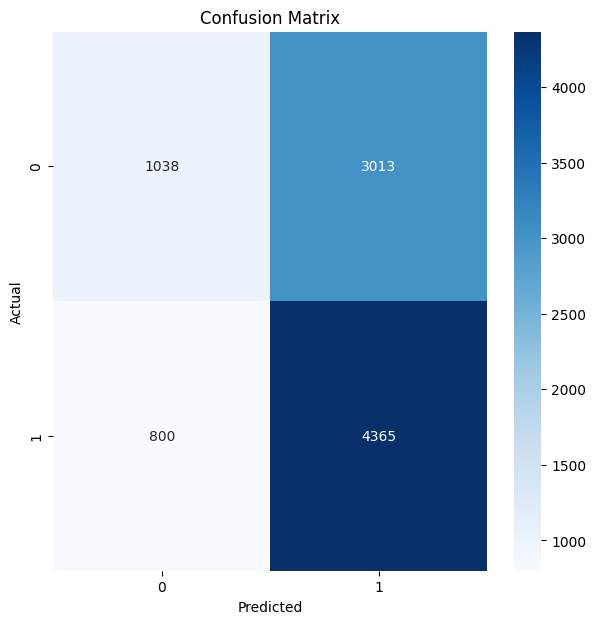

accuracy: 0.5862630208333334
classification report:
              precision    recall  f1-score   support

           0       0.56      0.26      0.35      4051
           1       0.59      0.85      0.70      5165

    accuracy                           0.59      9216
   macro avg       0.58      0.55      0.52      9216
weighted avg       0.58      0.59      0.55      9216
 


RandomForestClassifier:

train score is 1.0, test score is 0.5815972222222222


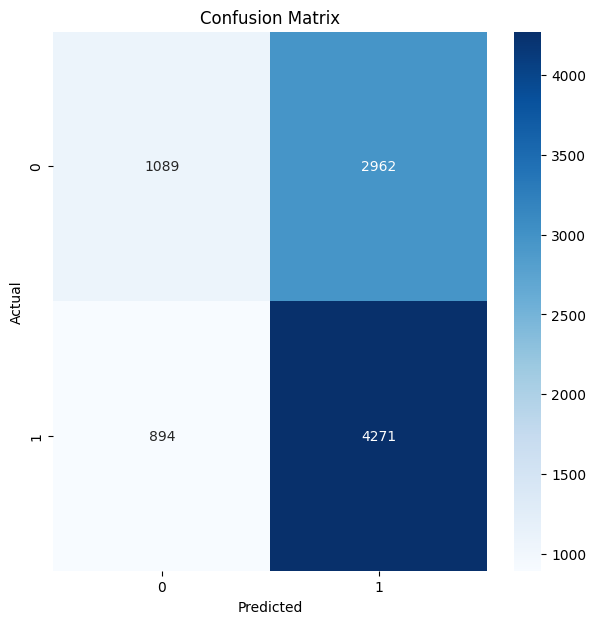

accuracy: 0.5815972222222222
classification report:
              precision    recall  f1-score   support

           0       0.55      0.27      0.36      4051
           1       0.59      0.83      0.69      5165

    accuracy                           0.58      9216
   macro avg       0.57      0.55      0.52      9216
weighted avg       0.57      0.58      0.54      9216
 


LinearSVC:

train score is 0.982421875, test score is 0.5662977430555556


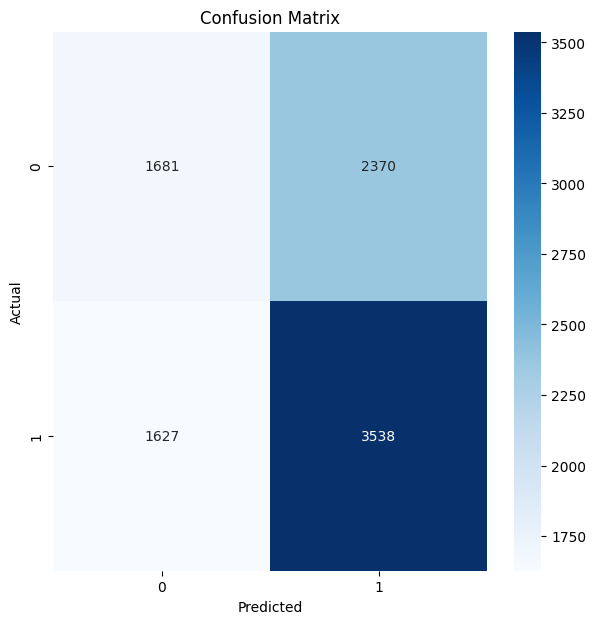

accuracy: 0.5662977430555556
classification report:
              precision    recall  f1-score   support

           0       0.51      0.41      0.46      4051
           1       0.60      0.68      0.64      5165

    accuracy                           0.57      9216
   macro avg       0.55      0.55      0.55      9216
weighted avg       0.56      0.57      0.56      9216
 


DecisionTreeClassifier:

train score is 1.0, test score is 0.5482855902777778


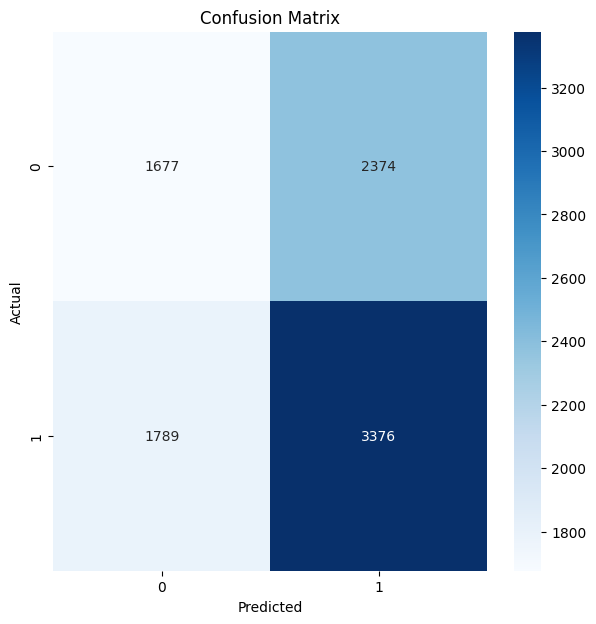

accuracy: 0.5482855902777778
classification report:
              precision    recall  f1-score   support

           0       0.48      0.41      0.45      4051
           1       0.59      0.65      0.62      5165

    accuracy                           0.55      9216
   macro avg       0.54      0.53      0.53      9216
weighted avg       0.54      0.55      0.54      9216
 


GradientBoostingClassifier:

train score is 0.7958984375, test score is 0.5801866319444444


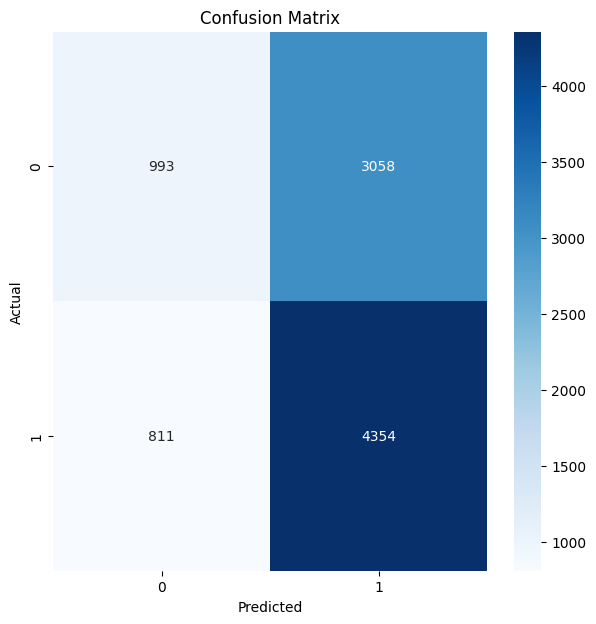

accuracy: 0.5801866319444444
classification report:
              precision    recall  f1-score   support

           0       0.55      0.25      0.34      4051
           1       0.59      0.84      0.69      5165

    accuracy                           0.58      9216
   macro avg       0.57      0.54      0.52      9216
weighted avg       0.57      0.58      0.54      9216
 




In [28]:
trained_models = {}
for name, model in models.items():
    print(f'{name}:\n')
    model = fit_predict(model, X_train_vectorized, y_train, X_test_vectorized, y_test)
    trained_models[name] = deepcopy(model)